# But what *is* the SVD?

Trefethen and Bau offer an interesting insight into what the SVD of a matrix is geometrically in Lecture 5.

In [4]:
import numpy as np
from plotly import __version__
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
init_notebook_mode(connected=True)
np.set_printoptions(suppress=True)

## Helper functions

In [5]:
def unit_sphere(n=100, dim=3):
    u = np.random.normal(0, 1, (100,3))
    d = np.linalg.norm(u, ord=2, axis=1)

    return u / d[:,None]

def make_hello():
    A = np.zeros((15,40))
    
    # H
    A[2:10,2:4] = A[5:7,4:6] = A[2:10,6:8] = 1
    
    # E
    A[3:11,10:16] = 1
    A[5,12:16] = A[8,12:16] = 0
    
    # L(1)
    A[4:12,18:24] = 1
    A[4:10,20:24] = 0
    
    # L(2)
    A[5:13,26:32] = 1
    A[5:11,28:32] = 0
    
    # O
    A[6:14,34:40] = 1
    A[8:12,36:38] = 0
    
    return A

## Low-Rank Approximations of *A*

Finding the SVD of a matrix at this point is trivial, but taking a closer look at the components of the SVD reveals some interesting properties of the matrix.

For now, let's stick to a 3-by-3 matrix.

In [6]:
A = np.array([[3, 4, 0], [-2, 3, 2], [-1, 0, -3]])
u, s, vh = np.linalg.svd(A)

u, s, vh

(array([[-0.84229524,  0.5386434 ,  0.02005017],
        [-0.48659496, -0.77585394,  0.40159185],
        [ 0.2318708 ,  0.3285026 ,  0.91559924]]),
 array([5.41221401, 3.81157166, 2.86004562]),
 array([[-0.32991427, -0.89223483, -0.30834005],
        [ 0.74487265, -0.04538501, -0.66566128],
        [-0.57993216,  0.44928522, -0.67957448]]))

Just looking at the numbers alone, we don't gain much understanding other than that *u*, *s*, and *vh* contain the eigenvalues and some orthogonal bases for *A*.

One way to think of $A$ is as the sum of $r$ rank-one matrices:

$$\begin{equation}
A = \sum_{j=1}^r \sigma_j u_j v_j^T
\label{rank_one}
\end{equation} $$

where, for $v\leq r$

$$\begin{equation}
A_v = \sum_{j=1}^v \sigma_j u_j v_j^T
\label{Av}
\end{equation}$$

In this definition, the "$A_v$ is the $v^{th}$ partial sum which captures as much of the energy of A as possible." I will revisit this point later.

For now, let's take a look at the three rank-one matrices $A_i$ calculated using Equation $\ref{rank_one}$.

In [7]:
Ai = [s[i] * np.outer(u[:,i], vh[i]) for i in range(3)]
Ai = np.stack(Ai, axis=0)

Ai

array([[[ 1.50397427,  4.06741497,  1.40562426],
        [ 0.86884771,  2.34975044,  0.8120308 ],
        [-0.41402077, -1.11969619, -0.38694654]],

       [[ 1.52928159, -0.09317896, -1.36665447],
        [-2.20275444,  0.13421358,  1.96850876],
        [ 0.93266338, -0.05682707, -0.83348193]],

       [[-0.03325586,  0.02576399, -0.03896979],
        [-0.66609327,  0.51603598, -0.78053956],
        [-1.51864261,  1.17652326, -1.77957153]]])

By taking the sum of these matrices as in Equation $\ref{rank_one}$, we get $A$.

In [8]:
np.sum(Ai, axis=0), np.allclose(A, np.sum(Ai, axis=0))

(array([[ 3.,  4.,  0.],
        [-2.,  3.,  2.],
        [-1.,  0., -3.]]), True)

The geometric interpretation of this is to approximate a hyperellipsoid $A$ with hyperellipsoids of increasing dimensions $A_v$.

To visualize this, we first need to map a unit sphere in $\mathbb{R}^3$ into a hyperellipsoid described by $A$.

In [9]:
X = unit_sphere(100, 3)
Ax = np.dot(X, A.T)

fig = go.Figure(data=[go.Scatter3d(x=X[:,0], y=X[:,1], z=X[:,2],
                                   mode='markers', name='unit sphere')])
fig.add_trace(go.Scatter3d(x=Ax[:,0], y=Ax[:,1], z=Ax[:,2],
                           mode='markers', name='hyperellipsoid'))
fig.show()

If you've learned about the SVD, it's likely that you've seen this image before. Now, let's try looking at the low-rank approximations of this hyperellipsoid. Here, $A_i x$ denotes the $i^{th}$ rank-one matrix $A_i$ multiplied by $x$.

In [10]:
Aix = np.tensordot(X, Ai, axes=((1), (2)))

fig = go.Figure(data=[go.Scatter3d(x=X[:,0], y=X[:,1], z=X[:,2],
                                   mode='markers', name='unit sphere')])
fig.add_trace(go.Scatter3d(x=Ax[:,0], y=Ax[:,1], z=Ax[:,2],
                           mode='markers', name='hyperellipsoid'))

for i in range(3):
    fig.add_trace(go.Scatter3d(x=Aix[:,i,0], y=Aix[:,i,1], z=Aix[:,i,2],
                           mode='markers', name='A_'+str(i+1)+'x'))

fig.show()

We can see that $A_i x$ are merely the axes of the hyperellipsoid where $A_1 x$ is the longest axis.

Similarly, we can visualize increasingly better approximations of $A$ using Equation $\ref{Av}$.

In [11]:
fig = go.Figure(data=[go.Scatter3d(x=X[:,0], y=X[:,1], z=X[:,2],
                                   mode='markers', name='unit sphere')])

Av = [np.sum(Ai[:i+1,:,:], axis=0) for i in range(3)]

for i in range(3):    
    Avx = np.tensordot(X, Av, axes=((1), (2)))
    
    fig.add_trace(go.Scatter3d(x=Avx[:,i,0], y=Avx[:,i,1], z=Avx[:,i,2],
                           mode='markers', name='Av_'+str(i+1)+'x'))

fig.show()

The figure very clearly shows how the approximation of $A$ by $A_v$ changes the corresponding hyperellipsoid.

$A_v$ when $v=1$ is simply the major axis of the hyperellipsoid. However, when $v=2$, the line transforms into an ellipse (2D ellipsoid) with the addition of the second-longest axis. And when $v=3$, the addition of the shortest axis transforms the ellipse into an ellipsoid.

## Image Compression

As pointed out by Trefethen and Bau, one application of this idea of low-rank approximations is image compression.

For this example, we have a binary image of the word "HELLO".

(15, 40)

/Users/Shion/anaconda3/envs/linalg/lib/python3.7/site-packages/matplotlib/font_manager.py:281: UserWarning:

Matplotlib is building the font cache using fc-list. This may take a moment.



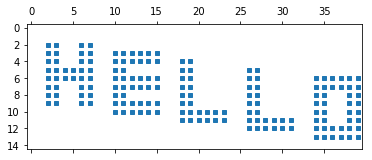

In [12]:
A = make_hello()

plt.spy(A, markersize=4);
A.shape

By taking the SVD of $A$, the matrix is decomposed into $U$, $\Sigma$, and $V^T$.

In [13]:
u, s, vh = np.linalg.svd(A)

u.shape, s.shape, vh.shape

((15, 15), (15,), (40, 40))

We can reconstruct $A$ as $A=U\Sigma V^T$.

True

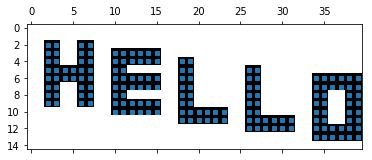

In [14]:
# k = min(m,n)
k = min(u.shape + vh.shape)

# Plot original matrix in solid black
plt.spy(A);

# Plot reconstructed matrix as blue squares
plt.spy(np.round(u @ np.diag(s) @ vh[:k,:]), markersize=4);

np.allclose(A, u @ np.diag(s) @ vh[:k,:])

We can also reconstruct the best rank-*i* approximation of A, which is given was given by Equation $\ref{Av}$:

$$ \begin{equation*}
A_v = \sum_{j=1}^v \sigma_j u_j v_j^T
\end{equation*} $$

The rank-one approximation of A looks like this:

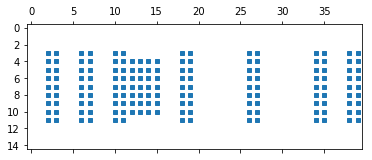

In [15]:
A1 = np.round(s[0] * np.outer(u[:,0], vh[0,:]))

plt.spy(A1, markersize=4);

We can also get any rank-$v$ approximation of $A$ by taking the sum as in the equation above.

In [16]:
# rank-v approximation of A
v = 2

# summation method
Av = np.round(sum([s[i] * np.outer(u[:k,i], vh[i,:]) for i in range(v)]))

The summation can also be written as a simple matrix operation and we can check to make sure that the two are equal.

In [17]:
# matrix multiplication method
Ai = np.round(u[:,:v] @ np.diag(s[:v]) @ vh[:v,:])

np.allclose(Av, Ai)

True

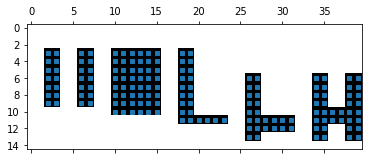

In [18]:
plt.spy(Av);
plt.spy(Ai, markersize=4);

Apart from deconstructing and reconstructing the matrix representing $A$, what can we do with the SVD of $A$? More importantly, what does the SVD of $A$ tell us *about* $A$?

First, calculate all possible rank-$r$ approximations of $A$.

In [19]:
# Calculate rank-r approximation of A for r=1,...,15
Ar = np.asarray([np.round(u[:,:i+1] @ np.diag(s[:i+1]) @ vh[:i+1,:]) for i in range(k)])

Ar.shape

(15, 15, 40)

Now, visualize these approximations in an interactive plot.

In [20]:
fig = go.Figure()

# Add rank-r matrix from 0 to k
for r in range(k):
    X = np.nonzero(Ar[r])
    
    fig.add_trace(
        go.Scatter(
            visible=False,
            name=str(r+1),
            x=X[1],
            y=X[0],
            mode='markers',
            marker_size=20))
    
fig.data[0].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method='restyle',
        args=["visible", [False] * len(fig.data)])
    step["args"][1][i] = True
    step["label"] = str(i+1)
    steps.append(step)

sliders = [dict(
    active=len(fig.data),
    currentvalue={"prefix": "rank: "},
    steps=steps)]
        
fig.update_layout(
    sliders=sliders,
    xaxis=dict(
        range=[0,40]),
    yaxis=dict(
        range=[15,0],
        scaleanchor='x',
        scaleratio=1))

fig.show()

## Resources

[Numerical Linear Algebra by Lloyd N. Trefethen and David Bau III](https://www.amazon.com/Numerical-Linear-Algebra-Lloyd-Trefethen/dp/0898713617)